# Multigroup Gaussian Processes

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
pyro.set_rng_seed(32)

noise_variance = torch.tensor(0.05)
n0, n1 = 100, 100


X0 = dist.Uniform(-10, 10).sample(sample_shape=(n0,))
X1 = dist.Uniform(-10, 10).sample(sample_shape=(n1,))

X = torch.concatenate([X0, X1], axis=0)

In [3]:
X_groups = torch.concatenate([torch.zeros(n0), torch.ones(n1)]).type(torch.LongTensor)

In [4]:
kernel_true = gp.kernels.MultiGroupRBF(input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(1), group_diff_param=torch.tensor(10))
cov = kernel_true.forward(X=X, groupsX=X_groups)+noise_variance.expand(n0+n1).diag()
Y = dist.MultivariateNormal(torch.zeros_like(X), cov).sample()

In [5]:
kernel = gp.kernels.MultiGroupRBF(input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(1), group_diff_param=torch.tensor(1))

gpr = gp.models.MultigroupGP(X, Y, kernel, X_groups, group_specific_noise_terms=True)


In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noises.detach().numpy())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

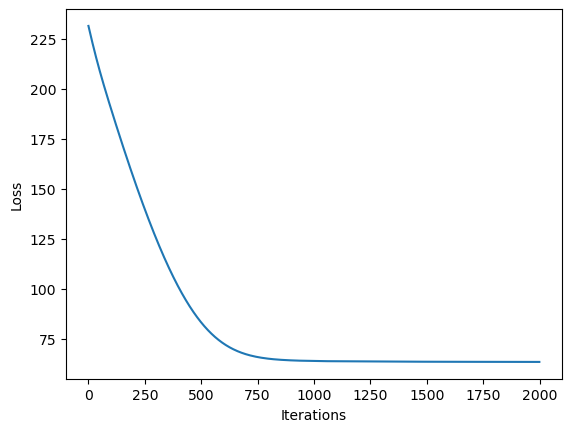

In [9]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

In [10]:
ntest = 200
Xtest_onegroup = torch.linspace(-10, 10, ntest)
Xtest = torch.concatenate([Xtest_onegroup, Xtest_onegroup], axis=0)
Xtest_groups = torch.concatenate([torch.zeros(ntest), torch.ones(ntest)]).type(torch.LongTensor)

In [21]:
mean, variance = gpr(Xtest, Xtest_groups)
mean = mean.detach()

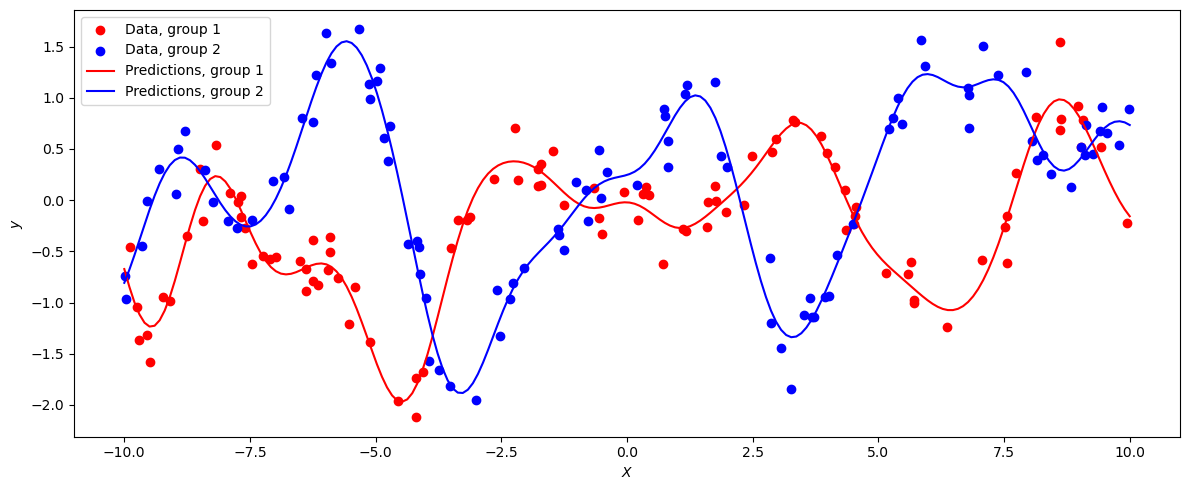

In [26]:
## Plot

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X[:n0], Y[:n0], color="red", label="Data, group 1")
ax.scatter(X[n0:], Y[n0:], color="blue", label="Data, group 2")
ax.plot(Xtest[:ntest], mean[:ntest], color="red", label="Predictions, group 1")
ax.plot(
    Xtest[ntest:], mean[ntest:], color="blue", label="Predictions, group 2"
)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()